# Frontera eficiente con simulaciones de muchos activos 

Vamos a analizar la problemática de calcular la frontera eficiente emplando simulaciones cuando hay un número elevado de activos.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import yfinance as yf
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
from scipy.interpolate import interp1d

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [12, 8]



pd.options.display.float_format = '{:.4%}'.format

In [3]:
# Date range
start = '2015-01-01'
end = '2019-12-30'

# Assets todos con retornos positivos
assets_positivos = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'HPQ', 'JCI', 'JPM',
        'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 'T', 'TGT', 'TMO',
        'TXT', 'VZ', 'ZION']

assets_muy_negativos = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'F', 'GE', 'HPQ', 
        'JCI', 'JPM','KHC', 'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 
        'T', 'TGT', 'TMO','TXT', 'VZ', 'ZION']

assets_un_negativo = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'F', 'HPQ', 
        'JCI', 'JPM', 'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 
        'T', 'TGT', 'TMO','TXT', 'VZ', 'ZION']

assets = assets_muy_negativos



# Downloading data
prices = yf.download(assets, start = start, end = end)['Adj Close']
prices.columns = assets

[*********************100%%**********************]  26 of 26 completed


In [4]:
#Calculamos los retornos logaritmicos
retornos = np.log(prices / prices.shift(1)).dropna()
retornos.head(2)

,BA,BAX,BMY,CMCSA,CNP,CPB,DE,F,GE,HPQ,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-07,1.8543%,-2.4752%,1.0757%,0.6419%,1.9579%,1.4909%,0.7402%,0.4049%,0.6063%,0.7496%,...,1.6491%,0.3577%,2.2570%,0.3248%,0.4483%,1.8163%,0.4285%,-0.3387%,0.4455%,-2.1060%
2015-07-08,-0.8629%,-1.6574%,-0.7208%,-1.3205%,-1.9579%,-0.8582%,-1.3805%,-3.2857%,-2.2156%,-1.1429%,...,0.1168%,-2.3246%,0.3109%,-2.3935%,-1.0229%,-1.1552%,-2.1223%,-2.8682%,-0.2573%,-2.6209%


In [5]:
#Calculamos la matriz de covarianzas y los retornos esperados
matriz_cov = retornos.cov().to_numpy() # Covariance matrix
retornos_esperados = retornos.mean().to_numpy() # Column vector expected return

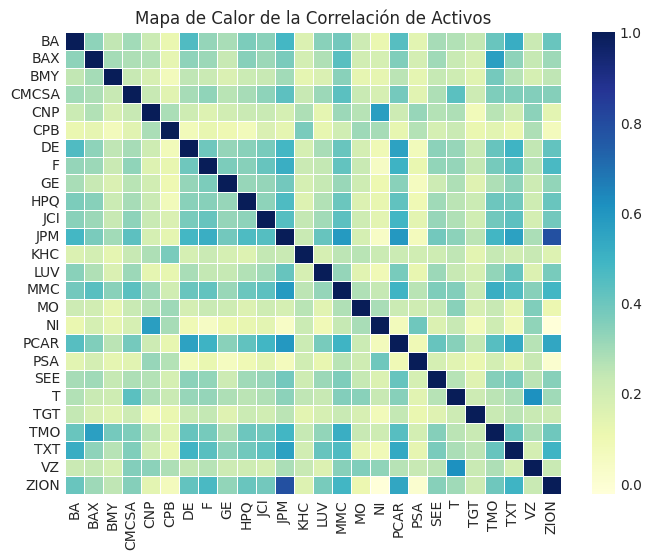

In [6]:
# Correlation matrix
mat_corr = retornos.corr().to_numpy() 

# Configurando el tamaño de la figura
plt.figure(figsize=(8, 6))
sns.heatmap(mat_corr, linewidths=.5, cmap="YlGnBu", xticklabels=retornos.columns, yticklabels=retornos.columns)
# Añadiendo título
plt.title("Mapa de Calor de la Correlación de Activos")

# Mostrando la gráfica
plt.show()

In [7]:
#defino número de activos y carteras
num_act = retornos.shape[1]
num_carteras = 20000

#Número de activos
num_act = prices.shape[1]

print(f'El número de activos es {num_act}')

El número de activos es 26


In [8]:
#genero pesos aleatorios
rng= np.random.default_rng(seed=4)
pesos = rng.random((num_carteras, num_act))
pesos /= np.sum(pesos, axis=1)[:, None] #normalizo

In [9]:
#calculo retornos y volatilidades
ret_carteras = retornos @ pesos.T

volatilidades = np.sqrt(np.var(ret_carteras)*252)
rentabilidades = 252*np.mean(ret_carteras, axis=0)

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Veamos las simulaciones y los activos en una gráfica.

¿Veis algo raro?

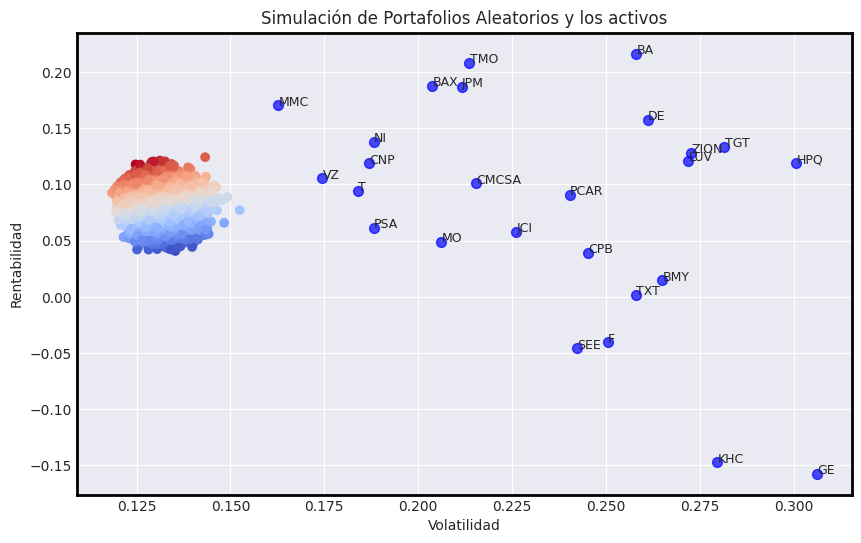

In [10]:
#grafico

plt.figure(figsize=(10, 6))
plt.scatter(volatilidades, rentabilidades, c=rentabilidades / volatilidades, marker='o', cmap='coolwarm')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)*252),252* retornos_esperados, color='blue', s=50, alpha=0.7)


# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]*252) + desplazamiento_x, 252*retornos_esperados[i] , asset, fontsize=9)
plt.xlabel('Volatilidad')
plt.ylabel('Rentabilidad')
plt.title('Simulación de Portafolios Aleatorios y los activos')
#plt.colorbar(label='Sharpe ratio')



# Configurar el borde de la figura
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)


plt.show()


## Veamos ahora la frontera eficiente de Markowitz

#### Calculamos la cartera de mínimo riesgo

In [11]:
#Variables de decisión
pesos = cp.Variable(num_act)

#Restricciones
constraints = [pesos >= 0,  # No shorting
               cp.sum(pesos) == 1, # Fully invested
               ]

#Función Objetivo
riesgo = cp.quad_form(pesos, matriz_cov) # Riesgo de la cartera
objective = cp.Minimize(riesgo) # Minimizar la varianza

ret = retornos_esperados.T @ pesos # Retorno esperado de la cartera

#Problema y resuelvo
prob = cp.Problem(objective, constraints)
resultado = prob.solve()

#Guardamos los valores de la rentabilidad y riesgo de la cartera de mínimo riesgo
min_riesgo = np.array([riesgo.value, ret.value])


Definimos los distintos valores de riesgo para calcular la frontera eficiente:

- Riesgo mínimo: El de la cartera de mínimo riesgo

- Riesgo máximo: El del activo de mayor riesgo

In [12]:
riesgos_lst = np.linspace(min_riesgo[0], np.diag(matriz_cov).max(), num=500)

Calculamos la cartera de mayor rentabilidad para cada uno de los riesgos anteriores.

In [13]:
retornos_lst = []
pesos_lst = []

for risk in riesgos_lst:
 #Variables de decisión
    pesos = cp.Variable(num_act)

    # Función objetivo
    rentabilidad = cp.Maximize(retornos_esperados.T @ pesos)

    #Restricciones
    riesgo = cp.quad_form(pesos, matriz_cov)

    constraints = [pesos >= 0,
                    cp.sum(pesos) == 1,
                    riesgo <= risk
                    ]

    prob = cp.Problem(rentabilidad, constraints)
    resultado = prob.solve(solver=cp.ECOS)
    retornos_lst.append(rentabilidad.value)
    pesos_lst.append(pesos.value)

/usr/local/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Creamos un dataframe con todos los resultados

In [14]:
resultados_df = pd.DataFrame({'riesgo': riesgos_lst, 'retornos': retornos_lst, 'pesos': pesos_lst})

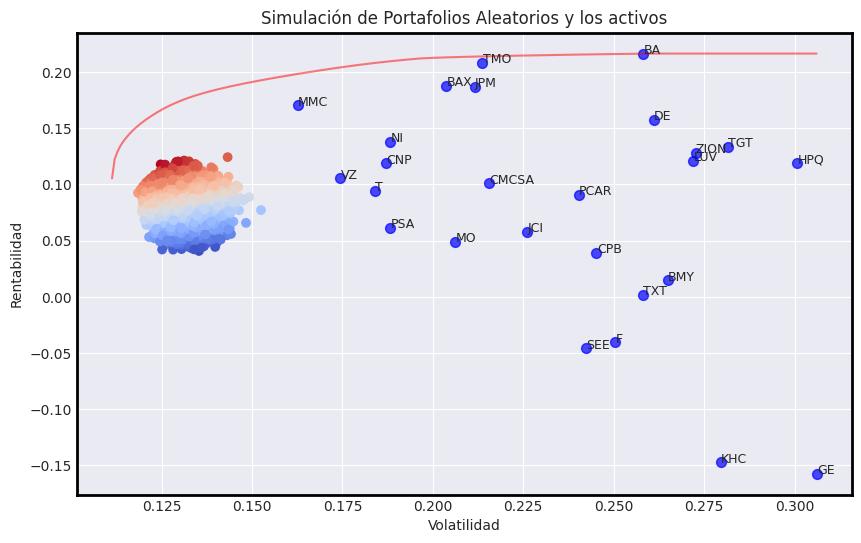

In [15]:
#grafico

plt.figure(figsize=(10, 6))
plt.scatter(volatilidades, rentabilidades, c=rentabilidades / volatilidades, marker='o', cmap='coolwarm')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)*252),252* retornos_esperados, color='blue', s=50, alpha=0.7)

plt.plot(np.sqrt(252*riesgos_lst), 252*np.array(retornos_lst), '-', color='red', label='Frontera Eficiente', alpha=0.5)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]*252) + desplazamiento_x, 252*retornos_esperados[i] , asset, fontsize=9)
plt.xlabel('Volatilidad')
plt.ylabel('Rentabilidad')
plt.title('Simulación de Portafolios Aleatorios y los activos')
#plt.colorbar(label='Sharpe ratio')



# Configurar el borde de la figura
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)


plt.show()


Genero una columna con el número de activos para cada cartera eficiente

In [32]:
resultados_df['num_activos'] = resultados_df['pesos'].apply(lambda x: np.sum(i > 10**-4 for i in x))

/tmp/ipykernel_26077/767307464.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  resultados_df['num_activos'] = resultados_df['pesos'].apply(lambda x: np.sum(i > 10**-4 for i in x))


Text(0.5, 1.0, 'Número de activos en la frontera eficiente')

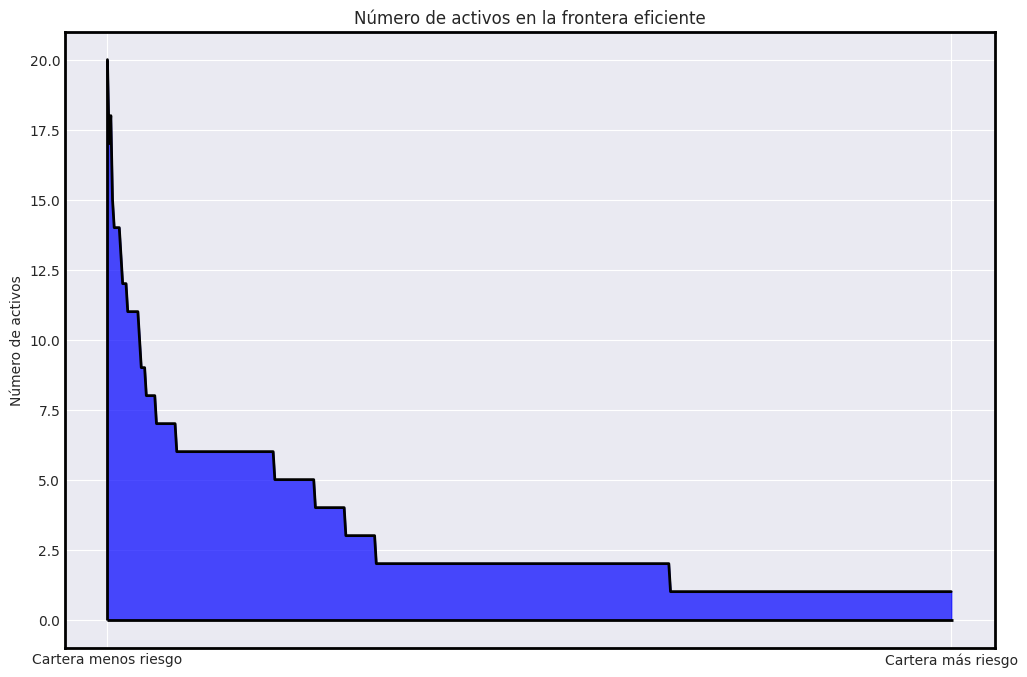

In [51]:
plt.fill_between(resultados_df.index, resultados_df['num_activos'], color='blue', alpha=0.7)

plt.plot(resultados_df['num_activos'], color='black', lw=2)


# Personalizando los ticks del eje X
plt.xticks([0, len(resultados_df.index)-1], ['Cartera menos riesgo', 'Cartera más riesgo'], )


# Configurar el borde de la figura
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.hlines(y=0, xmin=0, xmax=500, color='black', lw=2)
plt.vlines(x=0, ymin=0, ymax=20, color='black', lw=2)

plt.ylabel('Número de activos')
plt.title('Número de activos en la frontera eficiente')


¿Cómo son los pesos simulados cuando tienes muchos activos?

- Todos los pesos son muy parecidos (similares a cartera "equally weighted")
- Todos los pesos son distintos de cero

In [1]:
np.sum(pesos == 0)

NameError: name 'np' is not defined

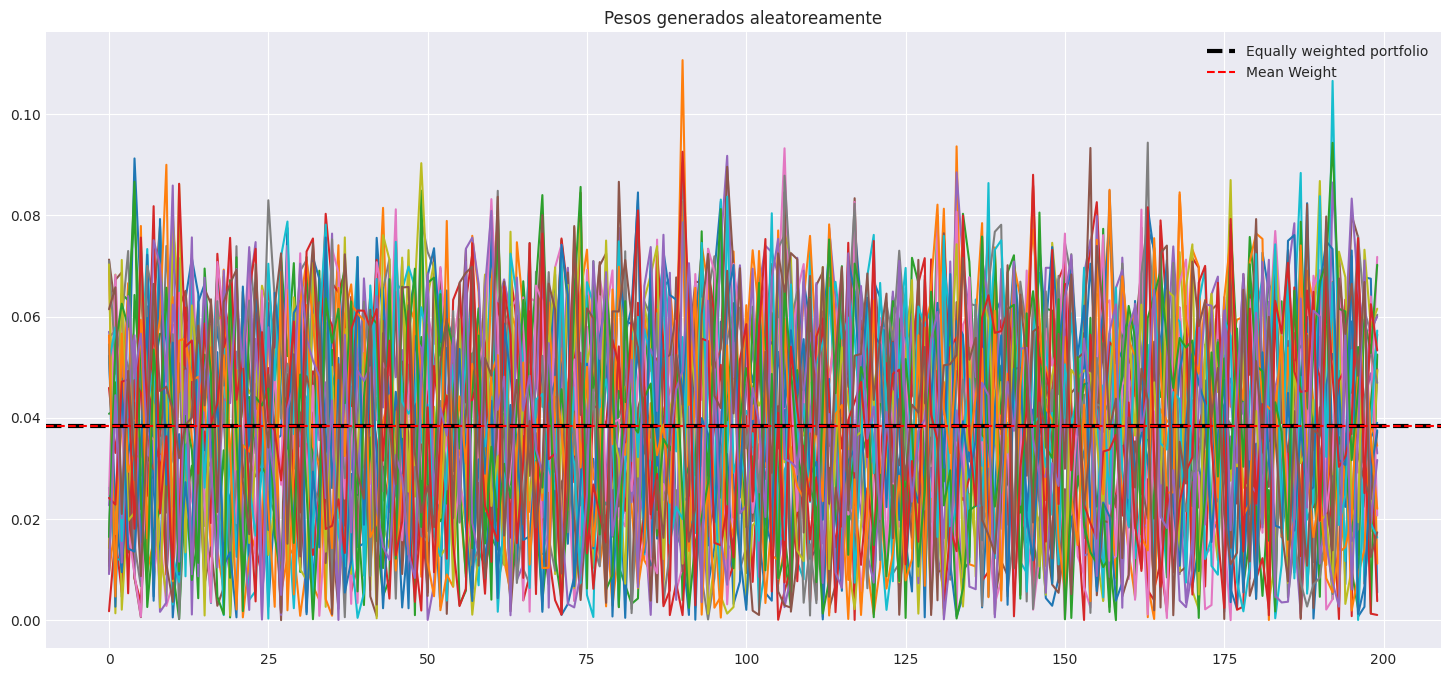

In [67]:
plt.figure(figsize=(18, 8))
plt.style.use('seaborn-v0_8-darkgrid')
plt.plot(pesos[200:400,]);
plt.axhline(1/num_act, c='black', ls='--', label = 'Equally weighted portfolio', lw=3)

plt.axhline(pesos.mean(), c='red', ls='--', label = 'Mean Weight')
plt.legend(loc='upper right')
plt.title('Pesos generados aleatoreamente');

Veamos un ejemplo de la composición de una caretra eficiente:
 - Tiene pocos activos
 - Los pesos de cada activo son grandes y muy diferentes

<img src="../imgs/pesos-cartera-eficiente.PNG"  alt="drawing" width="500"/>

Las carteras generadas se parece más a la cartea de mínimo riesgo.

Los componentes de la cartera de mínimo riesgo son:

<img src="../imgs/pesos-cartera-min-riesgo.PNG"  alt="drawing" width="500"/>